In [ ]:
#pip install wetterdienst
#pip install polars
#pip install pandas
#pip install matplotlib
#pip install numpy
#pip install tueplots
#pip install geopandas

In [2]:
# load packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
import geopandas as gpd

import polars as pl
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from wetterdienst import Settings
from wetterdienst.provider.dwd.observation import (
    DwdObservationDataset,
    DwdObservationParameter,
    DwdObservationPeriod,
    DwdObservationRequest,
    DwdObservationResolution,
)

from tueplots import bundles

In [3]:
#stations_1960 = pd.read_csv("C:/Users/kevin/Desktop/Data Literacy/Project/stations_1960", sep="\t", index_col=0)
#values_1960 = pd.read_csv("C:/Users/kevin/Desktop/Data Literacy/Project/values_1960", sep="\t", index_col=0)
#values_1960["date"] = pd.to_datetime(values_1960['date'])

#stations_2009 = pd.read_csv("C:/Users/kevin/Desktop/Data Literacy/Project/stations_2009", sep="\t", index_col=0)
#values_2009 = pd.read_csv("C:/Users/kevin/Desktop/Data Literacy/Project/values_2009", sep="\t", index_col=0)
#values_2009["date"] = pd.to_datetime(values_2009['date'])

## 1) Data:
Titel: Tägliche Stationsmessungen Niederschlagshöhe in mm
Kurzname: OBS_DEU_P1D_RR
- [Data Source](https://dwd-geoportal.de/products/OBS_DEU_P1D_RR/)
- [FTP-Server-Link](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/more_precip/recent/)
##### Easy access to data via [\"wetterdienst\"](https://pypi.org/project/wetterdienst/)-python library
[Code examples #1](https://github.com/earthobservations/wetterdienst/tree/main/examples),  
[Code examples #2](https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/Spatial-Interpolation/Data-sets-used/DWD-weather-data-East-Germany/index.html)

variables that are provided via wetterdienst: [Link](https://wetterdienst.readthedocs.io/en/latest/data/parameters.html)  
I'm intersted in --> PRECIPITATION_HEIGHT --> the amount of daily rain at each station in mm

the number of stations avilable for the defined period (1251, 8)
<class 'polars.dataframe.frame.DataFrame'>
┌────────────┬─────────────┬─────────────┬──────────┬───────────┬────────┬────────────┬────────────┐
│ station_id ┆ start_date  ┆ end_date    ┆ latitude ┆ longitude ┆ height ┆ name       ┆ state      │
│ ---        ┆ ---         ┆ ---         ┆ ---      ┆ ---       ┆ ---    ┆ ---        ┆ ---        │
│ str        ┆ datetime[μs ┆ datetime[μs ┆ f64      ┆ f64       ┆ f64    ┆ str        ┆ str        │
│            ┆ , UTC]      ┆ , UTC]      ┆          ┆           ┆        ┆            ┆            │
╞════════════╪═════════════╪═════════════╪══════════╪═══════════╪════════╪════════════╪════════════╡
│ 00001      ┆ 1937-01-01  ┆ 1986-06-30  ┆ 47.8413  ┆ 8.8493    ┆ 478.0  ┆ Aach       ┆ Baden-Würt │
│            ┆ 00:00:00    ┆ 00:00:00    ┆          ┆           ┆        ┆            ┆ temberg    │
│            ┆ UTC         ┆ UTC         ┆          ┆           ┆        ┆          

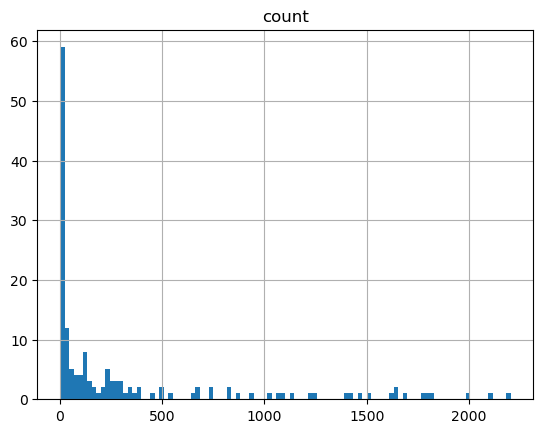

In [3]:
# get the data for 01.01.1960 - 31.12.2023
import polars as pl
_ = pl.Config.set_tbl_hide_dataframe_shape(True)
from wetterdienst import Settings
from wetterdienst.provider.dwd.observation import DwdObservationRequest

settings = Settings( # default
    ts_shape="long",  # tidy data
    ts_humanize=True,  # humanized parameters
    ts_si_units=True  # convert values to SI units
)

request = DwdObservationRequest(
   parameter=["PRECIPITATION_HEIGHT"],
   resolution="daily",
   start_date="1960-01-01",  # if not given timezone defaulted to UTC
   end_date="2023-12-31",  # if not given timezone defaulted to UTC
   settings=settings
).all()

# access the meta data of the staions
stations = request.df

print("the number of stations avilable for the defined period", stations.shape)
print(type(stations))
print(stations.head())

# access the desired weather data
values = request.values.all().df

print("the number of observations for all stations", values.shape)
print(type(values))
print(values.head())

stations_pandas = stations.to_pandas() # convert to pandas DataFrame
values_pandas = values.to_pandas() # convert to pandas DataFrame

# filter for stations that have data for the complete period 01.01.2009 to 31.12.2023
stations_df = stations_pandas[(stations_pandas['end_date'] > '2023-12-31') & (stations_pandas['start_date'] < '1960-01-02')]
print("(after filtering) number of stations that have data for the complete period 01.01.1960 to 31.12.2023", stations_df.shape)

# create a list with all the station_id's
station_list = stations_df["station_id"].tolist()

# filter the df with the rain values to only include the selected stations
values_df = values_pandas[values_pandas["station_id"].isin(station_list)]
print("(after filtering) number of observations for all selected stations", values_df.shape)

# For the period 01.01.1960 - 31.12.2023 there are 228 staions with 23.377 observations for each station  
# --> but there are NaN-values! --> remove staions with more then 10% NaN-values (Zolina et al., 2008 - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007JD008393)

missing_values = values_df[values_df['value'].isna()]

# count the number of missing values for each station
missing_values_counts = missing_values["station_id"].value_counts().reset_index().rename(columns={"index": "staion_id", 0: "count"})

# create a list with stations that >10% missing values
remove = missing_values_counts[missing_values_counts["count"] > 2337]
print("number of stations with >10% NaN-values", remove.shape)
remove_list = remove["station_id"].tolist()

# exlude these stations from the dataset
values_df = values_df[~values_df["station_id"].isin(remove_list)]
stations_df = stations_df[~stations_df["station_id"].isin(remove_list)]

# visualisation of NaN-value counts for each station in final dataset
missing_values_final = values_df[values_df['value'].isna()]
missing_values_counts_final = missing_values_final["station_id"].value_counts().reset_index().rename(columns={"index": "staion_id", 0: "count"})
print("visualisation of NaN-value counts for each station in final dataset", missing_values_counts_final.hist(bins=100))

values_1960 = values_df

# fill missing values with 0
# is replacing NaN-values with 0 a problem here? --> maybe not, because the median amount of rain is close to 0 anayway + it would only increase support for out null-hypothesis 
# --> that the amount/frequency of rain is decreasing in Germany
values_1960['value'] = values_1960['value'].fillna(0)

In [4]:
stations_1960 = stations_df

print(stations_1960.shape)
stations_1960.head()

(180, 8)


,station_id,start_date,end_date,latitude,longitude,height,name,state
9,00073,1959-03-01 00:00:00+00:00,2024-01-28 00:00:00+00:00,48.6183,13.0620,374.0,Aldersbach-Kramersepp,Bayern
23,00142,1955-01-01 00:00:00+00:00,2024-01-28 00:00:00+00:00,48.4060,11.3117,511.0,Altomünster-Maisbrunn,Bayern
24,00150,1951-01-01 00:00:00+00:00,2024-01-28 00:00:00+00:00,49.7273,8.1164,215.0,Alzey,Rheinland-Pfalz
25,00151,1947-01-01 00:00:00+00:00,2024-01-28 00:00:00+00:00,49.4691,11.8546,382.0,Amberg-Unterammersricht,Bayern
28,00164,1908-05-17 00:00:00+00:00,2024-01-28 00:00:00+00:00,53.0316,13.9908,54.0,Angermünde,Brandenburg


In [5]:
print(values_1960.shape)
values_1960.head()

(4207680, 6)


,station_id,dataset,parameter,date,value,quality
210384,00073,climate_summary,precipitation_height,1960-01-01 00:00:00+00:00,3.6,5.0
210385,00073,climate_summary,precipitation_height,1960-01-02 00:00:00+00:00,1.4,5.0
210386,00073,climate_summary,precipitation_height,1960-01-03 00:00:00+00:00,6.8,5.0
210387,00073,climate_summary,precipitation_height,1960-01-04 00:00:00+00:00,1.1,5.0
210388,00073,climate_summary,precipitation_height,1960-01-05 00:00:00+00:00,7.9,5.0


In [ ]:
# (optional) save data as csv-files 

#stations_1960.to_csv("stations_1960", sep='\t', encoding='utf-8')
#values_1960.to_csv("values_1960", sep='\t', encoding='utf-8')

the number of stations avilable for the defined period (1251, 8)
<class 'polars.dataframe.frame.DataFrame'>
┌────────────┬─────────────┬─────────────┬──────────┬───────────┬────────┬────────────┬────────────┐
│ station_id ┆ start_date  ┆ end_date    ┆ latitude ┆ longitude ┆ height ┆ name       ┆ state      │
│ ---        ┆ ---         ┆ ---         ┆ ---      ┆ ---       ┆ ---    ┆ ---        ┆ ---        │
│ str        ┆ datetime[μs ┆ datetime[μs ┆ f64      ┆ f64       ┆ f64    ┆ str        ┆ str        │
│            ┆ , UTC]      ┆ , UTC]      ┆          ┆           ┆        ┆            ┆            │
╞════════════╪═════════════╪═════════════╪══════════╪═══════════╪════════╪════════════╪════════════╡
│ 00001      ┆ 1937-01-01  ┆ 1986-06-30  ┆ 47.8413  ┆ 8.8493    ┆ 478.0  ┆ Aach       ┆ Baden-Würt │
│            ┆ 00:00:00    ┆ 00:00:00    ┆          ┆           ┆        ┆            ┆ temberg    │
│            ┆ UTC         ┆ UTC         ┆          ┆           ┆        ┆          

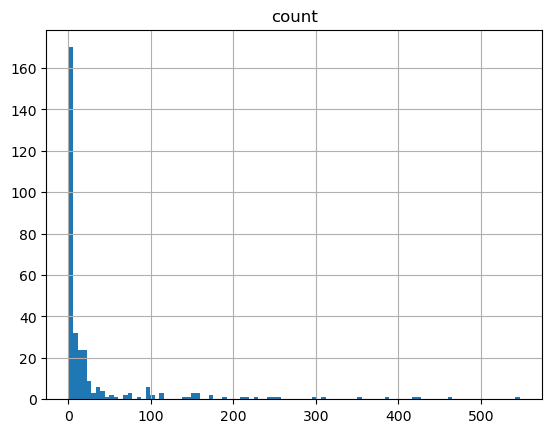

In [6]:
import polars as pl
_ = pl.Config.set_tbl_hide_dataframe_shape(True)
from wetterdienst import Settings
from wetterdienst.provider.dwd.observation import DwdObservationRequest

settings = Settings( # default
    ts_shape="long",  # tidy data
    ts_humanize=True,  # humanized parameters
    ts_si_units=True  # convert values to SI units
)

request = DwdObservationRequest(
   parameter=["PRECIPITATION_HEIGHT"],
   resolution="daily",
   start_date="2009-01-01",  # if not given timezone defaulted to UTC
   end_date="2023-12-31",  # if not given timezone defaulted to UTC
   settings=settings
).all()

# access the meta data of the staions
stations = request.df

print("the number of stations avilable for the defined period", stations.shape)
print(type(stations))
print(stations.head())

# access the desired weather data
values = request.values.all().df

print("the number of observations for all stations", values.shape)
print(type(values))
print(values.head())

stations_pandas = stations.to_pandas() # convert to pandas DataFrame
values_pandas = values.to_pandas() # convert to pandas DataFrame

# filter for stations that have data for the complete period 01.01.2009 to 31.12.2023
stations_df = stations_pandas[(stations_pandas['end_date'] > '2023-12-31') & (stations_pandas['start_date'] < '2009-01-02')]
print("(after filtering) number of stations that have data for the complete period 01.01.2009 to 31.12.2023", stations_df.shape)

# create a list with all the station_id's
station_list = stations_df["station_id"].tolist()

# filter the df with the rain values to only include the selected stations
values_df = values_pandas[values_pandas["station_id"].isin(station_list)]
print("(after filtering) number of observations for all selected stations", values_df.shape)

missing_values = values_df[values_df['value'].isna()]



# For the period 01.01.2009 - 31.12.2023 there are 522 staions with 5.478 observations for each station  
# --> but there are NaN-values! --> remove staions with more then 10% NaN-values [(Zolina et al., 2008)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007JD008393)

# count the number of missing values for each station
missing_values_counts = missing_values["station_id"].value_counts().reset_index().rename(columns={"index": "staion_id", 0: "count"})

# create a list with stations that >10% missing values
remove = missing_values_counts[missing_values_counts["count"] > 547]
print("number of stations with >10% NaN-values", remove.shape)
remove_list = remove["station_id"].tolist()

# exlude these stations from the dataset
values_df = values_df[~values_df["station_id"].isin(remove_list)]
stations_df = stations_df[~stations_df["station_id"].isin(remove_list)]

# visualisation of NaN-value counts for each station in final dataset
missing_values_final = values_df[values_df['value'].isna()]
missing_values_counts_final = missing_values_final["station_id"].value_counts().reset_index().rename(columns={"index": "staion_id", 0: "count"})
print("visualisation of NaN-value counts for each station in final dataset", missing_values_counts_final.hist(bins=100))

values_2009 = values_df

# fill missing values with 0
# is replacing NaN-values with 0 a problem here? --> maybe not, because the median amount of rain is close to 0 anayway + it would only increase support for out null-hypothesis 
# --> that the amount/frequency of rain is decreasing in Germany
values_2009['value'] = values_2009['value'].fillna(0)

stations_2009 = stations_df

print("final number of values for all stations: 2009-dataset", values_2009.shape)
print("final number of stations: 2009-dataset",stations_2009.shape)

In [ ]:
# (optional) save data as csv-files 

#stations_2009.to_csv("stations_2009", sep='\t', encoding='utf-8')
#values_2009.to_csv("values_2009", sep='\t', encoding='utf-8')

# Dataset:
a) for period 01.01.1960 - 31.12.2023
- stations_final --> 180 staions
- values_final --> 23.377 observations for each station
b) for period 01.01.2009 - 31.12.2023
- stations_final --> 450 staions
- values_final --> 5.478 observations for each station
# 1) Visualize the data:
Code for visualisation partly from here: [\"wetterdienst_notebook.ipynb\"](https://github.com/earthobservations/wetterdienst/blob/main/examples/wetterdienst_notebook.ipynb)

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


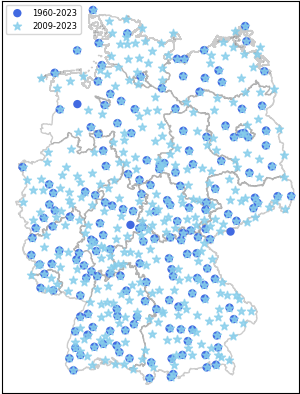

In [4]:
#cmap = plt.colormaps.get_cmap("Accent")
#bounds = np.quantile(stations_1960["height"], [0, 0.25, 0.5, 0.75, 1])
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

germany = gpd.read_file("C:/Users/kevin/Desktop/Data Literacy/Project/DEU_adm/DEU_adm1.shp")

# set plotting stylesheet with "tueplots"
plt.rcParams.update(bundles.icml2022(column="full", nrows=2, ncols=1, usetex=False))

fig, ax = plt.subplots(figsize=(4, 4) , tight_layout=True)

germany.plot(ax = ax, color='white', edgecolor='grey', alpha=0.4)

plt.scatter(stations_1960["longitude"], stations_1960["latitude"], color="royalblue", label="1960-2023", edgecolors="none") # cmap=cmap, norm=norm c=stations_1960["height"]
plt.scatter(stations_2009["longitude"], stations_2009["latitude"], color="skyblue", label="2009-2023", marker="*", alpha=0.8 ) # cmap=cmap, norm=norm c=stations_2009["height"]

plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 

#fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax)

#ax.set_title("Map of the 180 and 450 stations in the two datasets")
ax.legend(loc='best')
ax.set_xlim([5.4, 15.2])
ax.set_ylim([47.1, 55.2])

plt.savefig("stations.pdf", dpi=1000)

plt.show()

In [5]:
#values_1960.head()
#values_1960["value"].median()
#values_1960["value"].mean()
#values_1960["value"].max()
#values_1960["value"].min()
values_1960["value"].describe().apply(lambda x: format(x, 'f'))
values_2009["value"].describe().apply(lambda x: format(x, 'f'))

count    2465100.000000
mean           2.077611
std            4.738887
min            0.000000
25%            0.000000
50%            0.000000
75%            2.000000
max          167.600000
Name: value, dtype: object

## 1)  Hypotheses:
News articles of my local newspaper suggest --> 1) amount or 2) reliable frequency of rain in Germany is decreasing. Is this actually the case?
- did the amount of rain decrease significantly over the last years? (monthly average?)
- how is rainrall distributed? Did the disrtribution change?
- did periods with extreme amount of (no) rain change?
- Where August 22' (very dry) and August 23' (much rain) extremes? --> evidence for increase in variance, i.e. extreme weather?

##### Notes/Ideas for Plot below:
- 2022 and 2018 had very dry summers --> https://www.daswetter.com/nachrichten/vorhersage/duerre-rekord-deutschland-wetter-regenwetter-trockenheit.html, https://www.swr.de/swraktuell/baden-wuerttemberg/sommer-2022-in-bw-zu-heiss-und-zu-trocken-100.html  
- 2023 on the other hand had much rain --> https://www.spiegel.de/wissenschaft/natur/regen-in-deutschland-im-sommer-2023-ist-das-normal-wird-s-nochmal-warm-a-03421c38-75de-4615-8409-324e76477dbe
  
1mm entspricht 1 liter pro quadratmeter (https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv3=101904&lv2=101812)  
  
Why use 30 year periods? --> they are commonly used to analyze trends in climate (https://community.wmo.int/en/wmo-climatological-normals)  

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


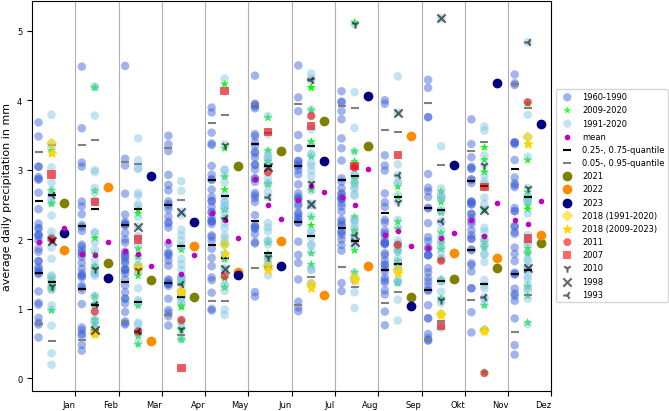

In [7]:
# figure 2
monthly_avg = values_1960.groupby(pd.PeriodIndex(values_1960['date'], freq="M"))['value'].mean().reset_index()
monthly_avg['month'] = monthly_avg['date'].dt.month
monthly_avg['year'] = monthly_avg['date'].dt.year
monthly_avg_long = monthly_avg.pivot(index="month", columns="year",  values="value")

monthly_avg_2 = values_2009.groupby(pd.PeriodIndex(values_2009['date'], freq="M"))['value'].mean().reset_index()
monthly_avg_2['month'] = monthly_avg_2['date'].dt.month
monthly_avg_2['year'] = monthly_avg_2['date'].dt.year
monthly_avg_long_2 = monthly_avg_2.pivot(index="month", columns="year",  values="value")

# create ranges for the plot
climate_period_1 = monthly_avg[monthly_avg["year"] <= 1990].year
climate_period_2 = monthly_avg[(monthly_avg["year"] <= 2020) & (monthly_avg["year"] > 1990)].year
period_2009 = monthly_avg_2[monthly_avg_2["year"] <= 2020].year

x_interval = [2,3,4,5,6,7,8,9,10,11,12,13]
x_range = [1.15,2.15,3.15,4.15,5.15,6.15,7.15,8.15,9.15,10.15,11.15,12.15]
x_range_2 = [1.45,2.45,3.45,4.45,5.45,6.45,7.45,8.45,9.45,10.45,11.45,12.45]
x_range_3 = [1.75,2.75,3.75,4.75,5.75,6.75,7.75,8.75,9.75,10.75,11.75,12.75]

x_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"]


#from tueplots.constants.color import rgb # color palette of Uni-Tübingen 
plt.rcParams.update(bundles.icml2022(column="full", nrows=2, ncols=2, usetex=False))


## period 1 --> 1960-1990
fig, ax = plt.subplots()

for year in  climate_period_1:
    plt.scatter(x_range, monthly_avg[monthly_avg["year"] == year].value,
             color="royalblue",
             alpha=0.05,
             edgecolors="none")
plt.scatter(x_range, monthly_avg[monthly_avg["year"] == 1960].value, color="royalblue", alpha=0.5, edgecolors="none", label="1960-1990")
plt.scatter(x_range_2, monthly_avg_2[monthly_avg_2["year"] == 2009].value, color="lime", marker="*", alpha=0.8, edgecolors="none", label="2009-2020")
plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 2020].value, color="skyblue", alpha=0.5, edgecolors="none", label="1991-2020")
# plot the the mean of the monthly averages of each year
plt.scatter(x_range, monthly_avg[monthly_avg["year"] <= 1990].groupby("month").mean().value, color="m", marker=".", label="mean")
# plot the quantile of the monthly averages of each year
plt.scatter(x_range, monthly_avg[monthly_avg["year"] <= 1990].groupby("month").quantile(0.25).value, color="black", marker="_")
plt.scatter(x_range, monthly_avg[monthly_avg["year"] <= 1990].groupby("month").quantile(0.75).value, color="black", marker="_")
plt.scatter(x_range, monthly_avg[monthly_avg["year"] <= 1990].groupby("month").quantile(0.05).value, color="grey", marker="_")
plt.scatter(x_range, monthly_avg[monthly_avg["year"] <= 1990].groupby("month").quantile(0.95).value, color="grey", marker="_")


## 2009-dataset
for year in period_2009:
    plt.scatter(x_range_2, monthly_avg_2[monthly_avg_2["year"] == year].value,       
                color="lime",
                marker="*",
                alpha=0.2,
                edgecolors="none")


## period 2 --> 1991-2020
for year in climate_period_2:
    plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == year].value,       
                color="skyblue",
                alpha=0.05,
                edgecolors="none")
plt.scatter(x_range_2, monthly_avg[(monthly_avg["year"] >= 1991) & (monthly_avg["year"] <= 2020)].groupby("month").mean().value, color="m", marker=".")
plt.scatter(x_range_2, monthly_avg[(monthly_avg["year"] >= 1991) & (monthly_avg["year"] <= 2020)].groupby("month").quantile(0.25).value, color="black", marker="_", label="0.25-, 0.75-quantile")
plt.scatter(x_range_2, monthly_avg[(monthly_avg["year"] >= 1991) & (monthly_avg["year"] <= 2020)].groupby("month").quantile(0.75).value, color="black", marker="_")
plt.scatter(x_range_2, monthly_avg[(monthly_avg["year"] >= 1991) & (monthly_avg["year"] <= 2020)].groupby("month").quantile(0.05).value, color="grey", marker="_", label="0.05-, 0.95-quantile")
plt.scatter(x_range_2, monthly_avg[(monthly_avg["year"] >= 1991) & (monthly_avg["year"] <= 2020)].groupby("month").quantile(0.95).value, color="grey", marker="_")

## plot the years 2021, 2022, 2023   
plt.scatter(x_range_3, monthly_avg[monthly_avg["year"] == 2021].value, color="olive", label="2021")
#plt.scatter(x_range_3, monthly_avg_2[monthly_avg_2["year"] == 2021].value, color="lime", marker="*")
plt.scatter(x_range_3, monthly_avg[monthly_avg["year"] == 2022].value, color="darkorange", label="2022")
#plt.scatter(x_range_3, monthly_avg_2[monthly_avg_2["year"] == 2022].value, color="lime", marker="*")
plt.scatter(x_range_3, monthly_avg[monthly_avg["year"] == 2023].value, color="navy", label="2023")
#plt.scatter(x_range_3, monthly_avg_2[monthly_avg_2["year"] == 2023].value, color="lime", marker="*")
plt.scatter(x_range_3, monthly_avg[monthly_avg["year"] >= 2021].groupby("month").mean().value, color="m", marker=".")

plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 2018].value, color="gold", marker="D", label="2018 (1991-2020)", alpha=0.6, edgecolors="none")
plt.scatter(x_range_2, monthly_avg_2[monthly_avg_2["year"] == 2018].value, color="gold", marker="*", label="2018 (2009-2023)")

## highlighting years with some "extreme" values

plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 2011].value, color="red", marker="8", edgecolors="none", alpha=0.6, label="2011")
plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 2007].value, color="red", marker="s", edgecolors="none", alpha=0.6, label="2007")

plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 2010].value, color="black", marker="1", alpha=0.6, label="2010")
plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 1998].value, color="black", marker="x", alpha=0.6, label="1998")
plt.scatter(x_range_2, monthly_avg[monthly_avg["year"] == 1993].value, color="black", marker="3", alpha=0.6, label="1993")



#ax.set_title("average monthly rainfall in mm for the period 1960 to 2023")
#ax.set_xlabel("Month")
ax.set_ylabel("average daily precipitation in mm")
ax.grid(which="major", axis="x")
ax.set_xticks(x_interval)
ax.set_xticklabels(x_labels)
plt.xticks(ha='right')
#plt.figure(figsize=(20,20), dpi=1000)
ax.set_xlim([1, 13])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("daily precipitation_average.pdf")
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


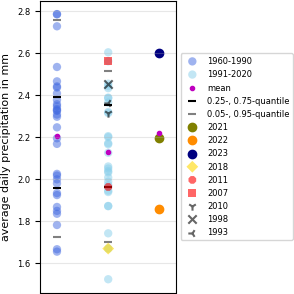

In [8]:
# plot yearly mean
year_avg = values_1960.groupby(pd.PeriodIndex(values_1960['date'], freq="Y"))['value'].mean().reset_index()
year_avg['year'] = year_avg['date'].dt.year
year_avg["period_1"] = 1
year_avg["period_2"] = 1.03
year_avg["period_3"] = 1.06


period_1 = year_avg[year_avg["year"] <= 1990]
period_2 = year_avg[(year_avg["year"] >= 1991) & (year_avg["year"] <= 2020)]
period_3 = year_avg[year_avg["year"] >= 2021]


#from tueplots.constants.color import rgb # color palette of Uni-Tübingen 
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=2, usetex=False))

fig, ax = plt.subplots(figsize=(3, 3) , tight_layout=True)

plt.scatter(period_1["period_1"].values, period_1["value"].values, color="royalblue", alpha=0.5, edgecolors="none", label="1960-1990")
plt.scatter(1, period_1["value"].mean(), color="m", marker=".")
plt.scatter(1, period_1["value"].quantile(0.25), color="black", marker="_")
plt.scatter(1, period_1["value"].quantile(0.75), color="black", marker="_")
plt.scatter(1, period_1["value"].quantile(0.05), color="grey", marker="_")
plt.scatter(1, period_1["value"].quantile(0.95), color="grey", marker="_")


plt.scatter(period_2["period_2"].values, period_2["value"].values, color="skyblue", alpha=0.5, edgecolors="none", label="1991-2020")
plt.scatter(1.03, period_2["value"].mean(), color="m", marker=".", label="mean")
plt.scatter(1.03, period_2["value"].quantile(0.25), color="black", marker="_", label="0.25-, 0.75-quantile")
plt.scatter(1.03, period_2["value"].quantile(0.75), color="black", marker="_")
plt.scatter(1.03, period_2["value"].quantile(0.05), color="grey", marker="_", label="0.05-, 0.95-quantile")
plt.scatter(1.03, period_2["value"].quantile(0.95), color="grey", marker="_")

plt.scatter(1.06, period_3[period_3["year"] == 2021].value, color="olive", label="2021")
plt.scatter(1.06, period_3[period_3["year"] == 2022].value, color="darkorange", label="2022")
plt.scatter(1.06, period_3[period_3["year"] == 2023].value, color="navy", label="2023")
plt.scatter(1.06, period_3["value"].mean(), color="m", marker=".")


# highlighting years with some "extreme" values
plt.scatter(1.03, period_2[period_2["year"] == 2018].value, color="gold", marker="D", label="2018", alpha=0.6, edgecolors="none")

plt.scatter(1.03, period_2[period_2["year"] == 2011].value, color="red", marker="8", edgecolors="none", alpha=0.6, label="2011")
plt.scatter(1.03, period_2[period_2["year"] == 2007].value, color="red", marker="s", edgecolors="none", alpha=0.6, label="2007")
plt.scatter(1.03, period_2[period_2["year"] == 2010].value, color="black", marker="1", alpha=0.6, label="2010")
plt.scatter(1.03, period_2[period_2["year"] == 1998].value, color="black", marker="x", alpha=0.6, label="1998")
plt.scatter(1.03, period_2[period_2["year"] == 1993].value, color="black", marker="3", alpha=0.6, label="1993")

# plot differences in seasons
# winter --> 12,01,02
# spring --> 03,04,05
# summer --> 06,07,08
# fall --> 09,10,11
ax.set_xlim([0.99, 1.07])

plt.tick_params(labelbottom = False, bottom = False) 
ax.grid(which="major", axis="y", alpha=0.3)
ax.set_ylabel("average daily precipitation in mm")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("yearly precipitation_average.pdf")
plt.show()

##### How is rain distributed?
Daily precipitation is a discrete process (rain or no rain), and it is well represented by an exponential negative distribution (Brooks and Carruthers, 1953)

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


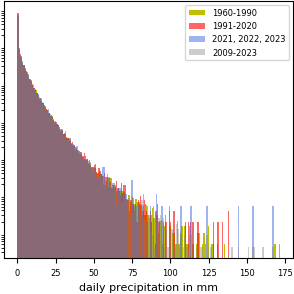

In [9]:
values_1960['month'] = values_1960['date'].dt.month
values_1960['year'] = values_1960['date'].dt.year

values_2009['month'] = values_2009['date'].dt.month
values_2009['year'] = values_2009['date'].dt.year


plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1, usetex=False))

# histogram for rain amount each day
fig, ax = plt.subplots(figsize=(3, 3))
plt.yscale('log') # make y-axis log scale
# period 1
n, bins, patches = ax.hist(values_1960[values_1960["year"] <= 1990].value, 178, density=True, color="y", label="1960-1990")
# period 2
n, bins, patches = ax.hist(values_1960[(values_1960["year"] >= 1991) & (values_1960["year"] <= 2000)].value, 178, density=True, color="r", alpha=0.6, label="1991-2020")
# 2021-2023
n, bins, patches = ax.hist(values_1960[values_1960["year"] >= 2021].value, 178, density=True,color="royalblue", alpha=0.5, label="2021, 2022, 2023")
# 2009-2023
n, bins, patches = ax.hist(values_2009.value, 178, density=True,color="grey", alpha=0.4, label="2009-2023")

ax.legend(loc='upper right')
plt.tick_params(left = False, labelleft = False) 
ax.set_xlabel("daily precipitation in mm")
plt.savefig("rain distribution.pdf")

plt.show()

Hypothesis form distribution of rain in above plot --> number of days with > ~70 mm rain decreased since 1990  
  
count --> number of days/periods with no rain (or < a treshhold)  
count --> number of days/periods with a lot of rain (or > a treshhold)  

In [173]:
period_1 = values_1960[values_1960["year"] <= 1990]
period_2 = values_1960[(values_1960["year"] > 1990) & (values_1960["year"] <= 2020)]
period_3 = values_1960[values_1960["year"] > 2020]

winter = [12, 1, 2]
spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]

period_1_winter = period_1[period_1['month'].isin(winter)]
period_1_spring = period_1[period_1['month'].isin(spring)]
period_1_summer = period_1[period_1['month'].isin(summer)]
period_1_fall = period_1[period_1['month'].isin(fall)]


period_2_winter = period_2[period_2['month'].isin(winter)]
period_2_spring = period_2[period_2['month'].isin(spring)]
period_2_summer = period_2[period_2['month'].isin(summer)]
period_2_fall = period_2[period_2['month'].isin(fall)]

period_3_winter = period_3[period_3['month'].isin(winter)]
period_3_spring = period_3[period_3['month'].isin(spring)]
period_3_summer = period_3[period_3['month'].isin(summer)]
period_3_fall = period_3[period_3['month'].isin(fall)]

season =["winter", "spring", "summer", "fall"]

period_1_values = pd.DataFrame(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]), columns=['winter', 'spring', 'summer', 'fall'], dtype="int64")

period_1_values.iloc[0,0] = len(period_1_winter[period_1_winter["value"] <= 1])/503640
period_1_values.iloc[1,0] = len(period_1_winter[(period_1_winter["value"] > 1) & (period_1_winter["value"] <= 50)])/503640
period_1_values.iloc[2,0] = len(period_1_winter[(period_1_winter["value"] > 50) & (period_1_winter["value"] <= 75)])
period_1_values.iloc[3,0] = len(period_1_winter[period_1_winter["value"] > 75])

period_1_values.iloc[0,1] = len(period_1_spring[period_1_spring["value"] <= 1])/513360
period_1_values.iloc[1,1] = len(period_1_spring[(period_1_spring["value"] > 1) & (period_1_spring["value"] <= 50)])/513360
period_1_values.iloc[2,1] = len(period_1_spring[(period_1_spring["value"] > 50) & (period_1_spring["value"] <= 75)])
period_1_values.iloc[3,1] = len(period_1_spring[period_1_spring["value"] > 75])

period_1_values.iloc[0,2] = len(period_1_summer[period_1_summer["value"] <= 1])/513360
period_1_values.iloc[1,2] = len(period_1_summer[(period_1_summer["value"] > 1) & (period_1_summer["value"] <= 50)])/513360
period_1_values.iloc[2,2] = len(period_1_summer[(period_1_summer["value"] > 50) & (period_1_summer["value"] <= 75)])
period_1_values.iloc[3,2] = len(period_1_summer[period_1_summer["value"] > 75])

period_1_values.iloc[0,3] = len(period_1_fall[period_1_fall["value"] <= 1])/507780
period_1_values.iloc[1,3] = len(period_1_fall[(period_1_fall["value"] > 1) & (period_1_fall["value"] <= 50)])/507780
period_1_values.iloc[2,3] = len(period_1_fall[(period_1_fall["value"] > 50) & (period_1_fall["value"] <= 75)])
period_1_values.iloc[3,3] = len(period_1_fall[period_1_fall["value"] > 75])

period_2_values = pd.DataFrame(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]), columns=['winter', 'spring', 'summer', 'fall'], dtype="int64")

period_2_values.iloc[0,0] = len(period_2_winter[period_2_winter["value"] <= 1])/487440
period_2_values.iloc[1,0] = len(period_2_winter[(period_2_winter["value"] > 1) & (period_2_winter["value"] <= 50)])/487440
period_2_values.iloc[2,0] = len(period_2_winter[(period_2_winter["value"] > 50) & (period_2_winter["value"] <= 75)])
period_2_values.iloc[3,0] = len(period_2_winter[period_2_winter["value"] > 75])

period_2_values.iloc[0,1] = len(period_2_spring[period_2_spring["value"] <= 1])/496800
period_2_values.iloc[1,1] = len(period_2_spring[(period_2_spring["value"] > 1) & (period_2_spring["value"] <= 50)])/496800
period_2_values.iloc[2,1] = len(period_2_spring[(period_2_spring["value"] > 50) & (period_2_spring["value"] <= 75)])
period_2_values.iloc[3,1] = len(period_2_spring[period_2_spring["value"] > 75])

period_2_values.iloc[0,2] = len(period_2_summer[period_2_summer["value"] <= 1])/496800
period_2_values.iloc[1,2] = len(period_2_summer[(period_2_summer["value"] > 1) & (period_2_summer["value"] <= 50)])/496800
period_2_values.iloc[2,2] = len(period_2_summer[(period_2_summer["value"] > 50) & (period_2_summer["value"] <= 75)])
period_2_values.iloc[3,2] = len(period_2_summer[period_2_summer["value"] > 75])

period_2_values.iloc[0,3] = len(period_2_fall[period_2_fall["value"] <= 1])/491400
period_2_values.iloc[1,3] = len(period_2_fall[(period_2_fall["value"] > 1) & (period_2_fall["value"] <= 50)])/491400
period_2_values.iloc[2,3] = len(period_2_fall[(period_2_fall["value"] > 50) & (period_2_fall["value"] <= 75)])
period_2_values.iloc[3,3] = len(period_2_fall[period_2_fall["value"] > 75])


period_3_values = pd.DataFrame(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]), columns=['winter', 'spring', 'summer', 'fall'], dtype="int64")

period_3_values.iloc[0,0] = len(period_3_winter[period_3_winter["value"] <= 1])/48600
period_3_values.iloc[1,0] = len(period_3_winter[(period_3_winter["value"] > 1) & (period_3_winter["value"] <= 50)])/48600
period_3_values.iloc[2,0] = len(period_3_winter[(period_3_winter["value"] > 50) & (period_3_winter["value"] <= 75)])
period_3_values.iloc[3,0] = len(period_3_winter[period_3_winter["value"] > 75])

period_3_values.iloc[0,1] = len(period_3_spring[period_3_spring["value"] <= 1])/49680
period_3_values.iloc[1,1] = len(period_3_spring[(period_3_spring["value"] > 1) & (period_3_spring["value"] <= 50)])/49680
period_3_values.iloc[2,1] = len(period_3_spring[(period_3_spring["value"] > 50) & (period_3_spring["value"] <= 75)])
period_3_values.iloc[3,1] = len(period_3_spring[period_3_spring["value"] > 75])

period_3_values.iloc[0,2] = len(period_3_summer[period_3_summer["value"] <= 1])/49680
period_3_values.iloc[1,2] = len(period_3_summer[(period_3_summer["value"] > 1) & (period_3_summer["value"] <= 50)])/49680
period_3_values.iloc[2,2] = len(period_3_summer[(period_3_summer["value"] > 50) & (period_3_summer["value"] <= 75)])
period_3_values.iloc[3,2] = len(period_3_summer[period_3_summer["value"] > 75])

period_3_values.iloc[0,3] = len(period_3_fall[period_3_fall["value"] <= 1])/49140
period_3_values.iloc[1,3] = len(period_3_fall[(period_3_fall["value"] > 1) & (period_3_fall["value"] <= 50)])/49140
period_3_values.iloc[2,3] = len(period_3_fall[(period_3_fall["value"] > 50) & (period_3_fall["value"] <= 75)])
period_3_values.iloc[3,3] = len(period_3_fall[period_3_fall["value"] > 75])

C:\Users\kevin\AppData\Local\Temp\ipykernel_16972\187634167.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6501270748947661' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  period_1_values.iloc[0,0] = len(period_1_winter[period_1_winter["value"] <= 1])/503640
C:\Users\kevin\AppData\Local\Temp\ipykernel_16972\187634167.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.66204028362163' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  period_1_values.iloc[0,1] = len(period_1_spring[period_1_spring["value"] <= 1])/513360
C:\Users\kevin\AppData\Local\Temp\ipykernel_16972\187634167.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6590677107682718' has dtype incompatible with int64, 

In [174]:
print(period_1_values)
print(period_2_values)
print(period_3_values)

       winter      spring      summer        fall
0    0.650127    0.662040    0.659068    0.688859
1    0.349553    0.337611    0.339329    0.310652
2  145.000000  164.000000  668.000000  213.000000
3   16.000000   15.000000  155.000000   35.000000
       winter      spring      summer        fall
0    0.654323    0.703235    0.673889    0.688079
1    0.345341    0.296300    0.324672    0.311516
2  144.000000  189.000000  610.000000  184.000000
3   20.000000   42.000000  105.000000   15.000000
      winter    spring     summer       fall
0   0.621481  0.701872   0.683152   0.669597
1   0.378292  0.297987   0.314855   0.330037
2  11.000000  7.000000  80.000000  15.000000
3   0.000000  0.000000  19.000000   3.000000
